This notebook is about the STAT 8056 homework on building recommender systems for the Movielens 100k data. Check [Github](https://github.umn.edu/YANG6367/movielens) for related data, code, and prediction results.


In [1]:
import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

from surprise import KNNBaseline, SVD, SVDpp
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import PredefinedKFold

data_dir = "../ml-100k"

# Predict for all users

For prediction, I choose the [KNNBaseline](https://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline) method and train the model on the whole rating dataset.

In [2]:
### read the full rating data
all_ratings = pd.read_csv(f"{data_dir}/u.data", sep = "\t", header=None)
all_ratings.columns = ['UserId', 'MovieId', 'Rating', 'Timestamp']
print(len(all_ratings['UserId'].unique()))
print(len(all_ratings['MovieId'].unique()))
all_ratings

943
1682


,UserId,MovieId,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [3]:
## Train the KNNBaseline model on the full dataset
# Load the movielens-100k dataset
file_path = os.path.expanduser(f'{data_dir}/u.data')
reader = Reader(line_format='user item rating timestamp', sep = '\t')
trainset = Dataset.load_from_file(file_path, reader=reader)
trainset = trainset.build_full_trainset()

# Build an algorithm, and train it.
algo = KNNBaseline()
algo.fit(trainset)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [4]:
## make predictions for all users on all movies
pred_df = pd.DataFrame([(u, i) for u in sorted(all_ratings['UserId'].unique()) for i in sorted(all_ratings['MovieId'].unique())], columns=['UserId', 'MovieId'])
pred_df['PredScore'] = pred_df.apply(lambda row: algo.predict(str(row['UserId']), str(row['MovieId']), verbose=False).est, axis = 1)
pred_df.to_csv('../results/knnbaseline-pred.csv')
pred_df

,UserId,MovieId,PredScore
0,1,1,3.981066
1,1,2,3.189148
2,1,3,3.305977
3,1,4,3.763536
4,1,5,3.228352
...,...,...,...
1586121,943,1678,3.187539
1586122,943,1679,3.369357
1586123,943,1680,3.278448
1586124,943,1681,3.474314


# Compare different methods

Three methods are compared: [KNNBaseline](https://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline), [SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD), and [SVD++](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp). Their CV Mean RMSE are 0.932288, 0.937806, 0.922464 respectively. Note that the difference between SVD++ and SVD is that SVD takes into account implicit ratings. From the CV results, we can see that SVD++ is the best performer and this also demonstrates the usefulness of incorporating the non-random missing pattern information empirically.

In [5]:
##============  Read Dataset  ==============##
# path to dataset folder
files_dir = os.path.expanduser('../ml-100k/')

# This time, we'll use the built-in reader.
reader = Reader('ml-100k')

# folds_files is a list of tuples containing file paths:
# [(u1.base, u1.test), (u2.base, u2.test), ... (u5.base, u5.test)]
train_file = files_dir + 'u%d.base'
test_file = files_dir + 'u%d.test'
folds_files = [(train_file % i, test_file % i) for i in (1, 2, 3, 4, 5)]

data = Dataset.load_from_folds(folds_files, reader=reader)
pkf = PredefinedKFold()

##============  KNNBaseline  ==============##
print(f"\nKNNBaseline:")
algo = KNNBaseline()
rmse_list = []
for trainset, testset in pkf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
print(f"Mean RMSE: {np.array(rmse_list).mean()}")

##============  SVD  ==============##
print(f"\nSVD:")
algo = SVD()
rmse_list = []
for trainset, testset in pkf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
print(f"Mean RMSE: {np.array(rmse_list).mean()}")

##============  SVD++  ==============##
print(f"\nSVD++:")
algo = SVDpp()
rmse_list = []
for trainset, testset in pkf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
print(f"Mean RMSE: {np.array(rmse_list).mean()}")


KNNBaseline:
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9418
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9346
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9292
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9260
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9299
Mean RMSE: 0.9322884335480263

SVD:
RMSE: 0.9522
RMSE: 0.9412
RMSE: 0.9332
RMSE: 0.9300
RMSE: 0.9324
Mean RMSE: 0.937805840280969

SVD++:
RMSE: 0.9372
RMSE: 0.9245
RMSE: 0.9170
RMSE: 0.9164
RMSE: 0.9172
Mean RMSE: 0.9224637249265116


# Examine the Missing Pattern

### Mssing pattern analysis
- The right-skewed distribution of user ratings indicates that only a few users rated a large number of movies and most of the users rated only a few movies.
- The figure of movie ratings shows that popular movies attract more users and more ratings.

### Why incorporating the missing pattern helps with the prediction performance?
- Intuitively, users implicitly tell us about their preferences by choosing to rate, regardless of the rating values. Namely, users deliberately choose which movies to rate and they are more likely to see movies that they think they will like (Marlin et al. 2007). Such implicit feedback information provides additional indication of user preferences.
- The conventional SVD method cannot handle the cold start problem, but with the help of missing pattern information, we are able to make predictions for new items.
- When missing data is not missing at random, then the maximum likelihood inference will be biased. Ignoring the missing pattern in predicting ratings can significantly impact the prediction performance, as demonstrated in the synthetic data experiments in Marlin et al. 2005.

### Empirical Validation
As suggested in the method comparison result, SVD++, which incorporates the missing pattern information, outperforms the conventional SVD by 1.6%, and this corroborates our analysis above.

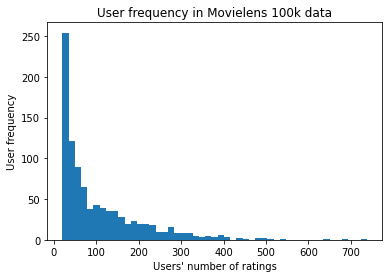

In [6]:
user_rating = all_ratings[['UserId', 'Rating']]
user_rating_count = user_rating.groupby('UserId').count().values
# generate the histogram
plt.hist(user_rating_count, bins=np.linspace(user_rating_count.min(), user_rating_count.max()+1, num=50))
plt.xlabel("Users' number of ratings")
plt.ylabel("User frequency")
plt.title("User frequency in Movielens 100k data")
plt.show()

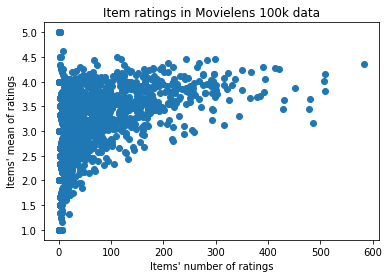

In [7]:
movie_rating = all_ratings[['MovieId', 'Rating']]
movie_rating_mean = movie_rating.groupby('MovieId').mean()
movie_rating_count = movie_rating.groupby('MovieId').count()
# generate the scatter plot
plt.scatter(movie_rating_count, movie_rating_mean)
plt.xlabel("Items' number of ratings")
plt.ylabel("Items' mean of ratings")
plt.title("Item ratings in Movielens 100k data")
plt.show()

# References
- [Matrix Factorization for Movie Recommendations in Python](https://beckernick.github.io/matrix-factorization-recommender/)
- [Surprise Github](https://github.com/NicolasHug/Surprise)
- Ricci, Francesco, Lior Rokach, and Bracha Shapira. "Introduction to recommender systems handbook." [Recommender systems handbook](https://www.cse.iitk.ac.in/users/nsrivast/HCC/Recommender_systems_handbook.pdf). Springer, Boston, MA, 2011. 1-35.
- Marlin, Benjamin M., et al. "Collaborative filtering and the missing at random assumption." Proceedings of the Twenty-Third Conference on Uncertainty in Artificial Intelligence. 2007.
- Marlin, Benjamin M., Sam T. Roweis, and Richard S. Zemel. "Unsupervised Learning with Non-Ignorable Missing Data." AISTATS. 2005.
